<a href="https://colab.research.google.com/github/pi4imu/work-in-iki/blob/master/effective_radius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.io import fits
from astropy.wcs import WCS

from scipy.optimize import curve_fit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/IKI/Микролинзирование/

Mounted at /content/drive
/content/drive/My Drive/IKI/Микролинзирование


Взял из другой своей программы функции, вырезающие кружок из карты:

In [ ]:
from matplotlib.patches import Rectangle

def createMyMask(rad_pix, size):
    
    w = 2*size
    h = 2*size
    
    center = [size, size]
    
    dist_from_center = np.zeros((w, h))
    z = dist_from_center*0    
      
    delta=1 
    x = np.arange(0, w, delta)
    y = np.arange(0, h, delta)

    Y, X = np.meshgrid(x,y)

    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    
    for i in range(0, w):
        for j in range(0, h):
            if dist_from_center[i][j] < rad_pix:
                z[i][j] = 1
            else:
                z[i][j] = 0
    
    return z#/np.sum(z)

#Функция, которая вырезает кружок из карты.

def cut_circle(image, size, center, rad_pix, graphics):
    
    kusok = np.zeros((2*size, 2*size))
    
    for i in range(center[1]-size, center[1]+size):
        for j in range(center[0]-size, center[0]+size):
             kusok[i - (center[1]-size)][j - (center[0]-size)] = image[i][j]
    
    circle_ones = createMyMask(rad_pix, size)
    mult = np.multiply(circle_ones, kusok)
    
    if graphics:
        
        plt.imshow(image, origin='lower')
        plt.colorbar()
        plt.gca().add_patch( Rectangle( (center[0]-rad_pix, center[1]-rad_pix), 2*rad_pix, 2*rad_pix, fill=None))
        plt.show()

        plt.imshow(kusok, origin='lower')
        plt.colorbar()
        plt.show()

        plt.imshow(mult, origin='lower')
        plt.colorbar()
        plt.show()
    
    return mult

Заголовок fits-файла.

In [ ]:
map = fits.open("maps/hlsp_frontier_hst_acs-30mas_macs1149_f606w_v1.0-epoch2_drz.fits")

image = map[0].data
header = map[0].header

w = WCS(header)
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 177.3946025  22.40132035  
CRPIX : 5400.0  5400.0  
CD1_1 CD1_2  : -8.3333333333333e-06  0.0  
CD2_1 CD2_2  : 0.0  8.33333333333334e-06  
NAXIS : 10800  10800

Переведём координаты галактики-линзы в пиксели на объявленной выше карте:

In [ ]:
RA = 177.397782
DEC = 22.395448

px, py = w.wcs_world2pix(RA, DEC, 0)

# Find the nearest integer pixel
px = np.round(px).astype(int)
py = np.round(py).astype(int)

print(px, py)

5046 4694


Заодно посмотрим, где находятся изображения S1-S4.

In [ ]:
SN1_lon,SN1_lat = 177.398225, 22.395628
SN2_lon,SN2_lat = 177.397713, 22.395781
SN3_lon,SN3_lat = 177.397371, 22.395531
SN4_lon,SN4_lat = 177.3978, 22.395181

SN_lon = np.array([SN1_lon,SN2_lon,SN3_lon,SN4_lon])
SN_lat = np.array([SN1_lat,SN2_lat,SN3_lat,SN4_lat])

px1, py2 = w.wcs_world2pix(SN_lon, SN_lat, 0)

# Find the nearest integer pixel
px1 = np.round(px1).astype(int)
py2 = np.round(py2).astype(int)

print(px1, py2)

[4997 5054 5092 5044] [4716 4734 4704 4662]


Нарисуем нужную нам область и положения изображений.

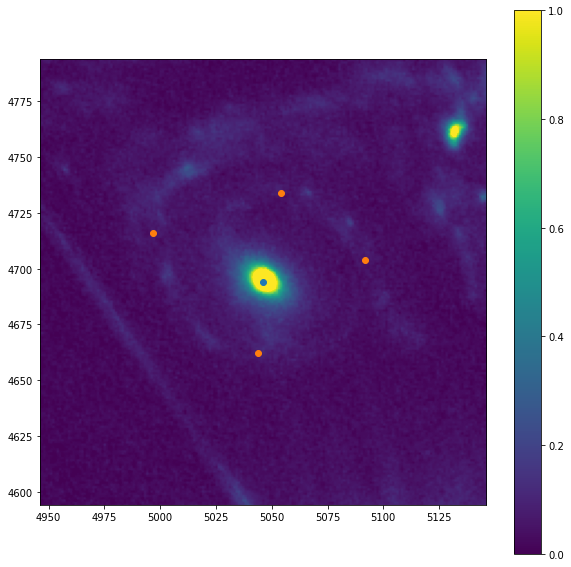

In [ ]:
image_data = fits.getdata("maps/hlsp_frontier_hst_acs-30mas_macs1149_f606w_v1.0-epoch2_drz.fits")

r = 100

plt.figure(figsize=(10,10))
plt.imshow(image_data, origin='lower', vmin=0, vmax = 0.1)
plt.xlim(px-r, px+r)
plt.ylim(py-r, py+r)
plt.scatter(px, py)
plt.scatter(px1, py2)
plt.colorbar()
plt.show()


Посмотрим на профиль яркости:

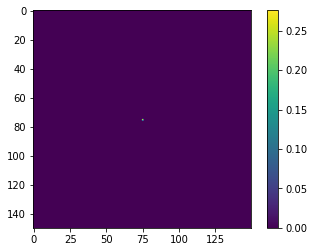

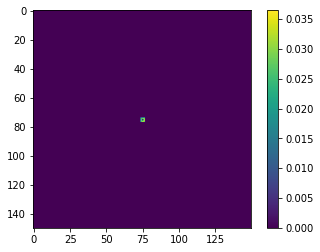

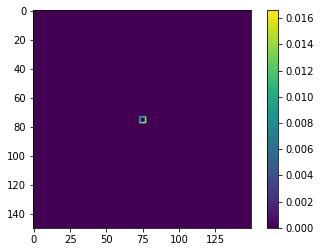

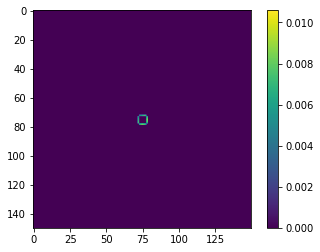

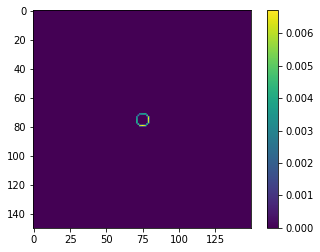

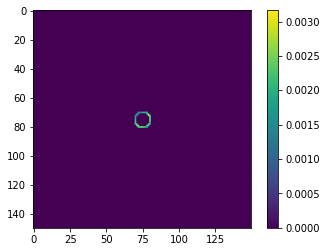

In [ ]:
br = []

length = 50
rs = np.linspace(0, length, length)

for i in range(0, length):
    
  cut1 = cut_circle(image_data, int(1.5*length), (px,py), i, False)
  cut2 = cut_circle(image_data, int(1.5*length), (px,py), i+1, False)
  cut = cut2-cut1

  brightness = (cut).sum()
  area = np.count_nonzero(cut)
  #print(area)
  #print(cut[cut>0])
  br.append(brightness/area)

  plt.imshow(cut/area)
  plt.colorbar()
  plt.show()

plt.plot(rs, br)
plt.show()

Подгоним профиль яркости под профиль де Вокулёра (фитируем при помощи scipy):

In [ ]:
def de_voc(r, I, r_e):

  return I*np.exp(-7.67*( (r/r_e)**(1/4) - 1) )

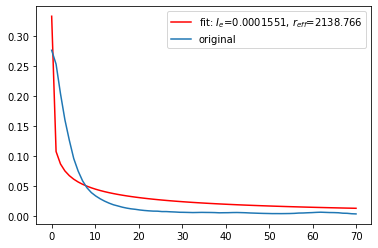

In [ ]:
popt, pcov = curve_fit(de_voc, rs, br)

plt.plot(rs, de_voc(rs, *popt), 'r-', label='fit: $I_e$=%5.7f, $r_{eff}$=%5.3f' % tuple(popt))
plt.plot(rs, br, label = 'original')
plt.legend()
plt.show()

Могу сказать, что фиттированием довольно точно найдена яркость в центре галактики (если умножить $I_e$ на $e^{7.67} \approx 2143$, получится как раз численное значение в центре). А вот эффективный радиус явно не вяжется. 

Это то, что уже было раньше. Идея следующая: будем увеличивать радиус смотреть на суммарную светимость внутри него и строить зависимость её от радиуса:

Effective radius: 24 pixels


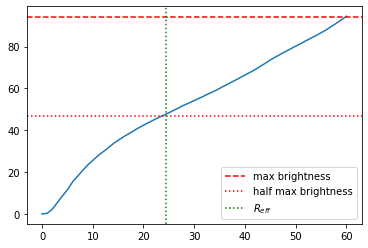

In [ ]:
sum_br=[]
max_rad = 60
radii = np.linspace(0, max_rad, max_rad)

for radius in range(0, max_rad):
 sum_br.append( cut_circle(image_data, 100, (px,py), radius, False).sum() )

plt.plot(radii, sum_br)
plt.axhline(int(np.max(sum_br)), color='r', linestyle = '--', label='max brightness')
plt.axhline(int(np.max(sum_br)/2), color='r', linestyle = ':', label='half max brightness')

r_eff = radii[ np.argmin(np.abs(sum_br - np.max(sum_br)/2)) ]
plt.axvline(r_eff, color='g', linestyle = ':', label='$R_{eff}$')
print('Effective radius:', int(r_eff), 'pixels')

plt.legend()
plt.show()

Понятно, что это довольно условно, ведь галактика не сферически симметричная. Но в первом приближении оценка неплохая (на мой взгляд). Из header'а фитс-файла можно найти, что разрешение карты 0,03 угловых секунды на пиксель. Найдём эффективный радиус единицах длины:

In [ ]:
scale = 0.03

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

zl=0.541

Dl = cosmo.angular_diameter_distance(zl)

Dl*(r_eff*scale/3600*np.pi/180)

<Quantity 0.00441706 Mpc>

То есть эффективный радиус порядка 4,4 кпк. 

При этом по предыдущим оценкам получалось 4,93 кпк (https://arxiv.org/abs/1405.0038 и начало [вот этого](https://colab.research.google.com/drive/1GIxBW8ao4V6Iink2jegSIzApxlPAd2Ip) ноутбука).
